In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from random import choices
from random import shuffle

import GUIDE

** **

**Spike and Slab Model (sing Gaussian distributions of different standard deviations for both spike and slab):**

In [276]:
rng = np.random.default_rng()

M=10000
L=10
T=100

print("M = ",M, ", L = ",L, ", T = ",T)


# effect sizes or network weights from variants to latents, latents to phenos
# drawn independently from spike-and-slab (more precisely, point-normal) dist

# # simulate new data
s_1 = 1
s_2 = 5

a = rng.choice([s_1,s_2],p=[0.7,0.3],size=(M,L))
b = rng.choice([s_1,s_2],p=[0.8,0.2],size=(L,T))
X = rng.normal(0, a, size=(M, L)) 
#Y = rng.exponential(b, size=(L, T)) 
Y = rng.normal(0, b, size=(L, T))  
 


eps = 1e-2
noise = rng.normal(0, eps, size=(M, T))
G = X@Y + noise


M =  10000 , L =  10 , T =  100


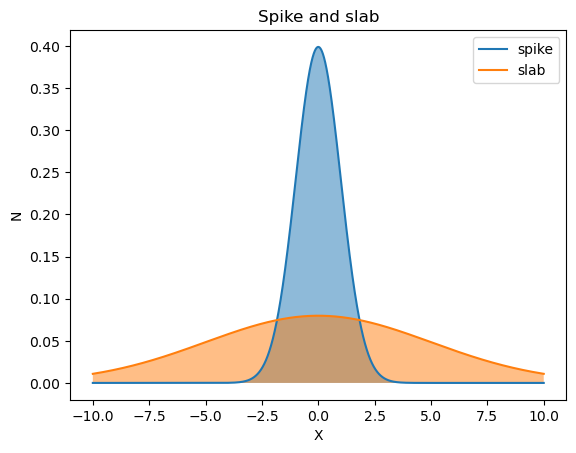

In [277]:
b = 10
lin_list =np.linspace(-b,b,L*M)

arg=-lin_list**2/2

spike = (np.sqrt(2*np.pi)*s_1)**(-1)*np.exp(arg/s_1**2)
slab = (np.sqrt(2*np.pi)*s_2)**(-1)*np.exp(arg/s_2**2)

plt.plot(lin_list,spike,label="spike")
plt.plot(lin_list,slab,label="slab")

plt.fill_between(lin_list,spike,alpha=0.5)
plt.fill_between(lin_list,slab,alpha=0.5)
plt.title("Spike and slab")
plt.xlabel("X")
plt.ylabel("N")
plt.legend(loc='upper right')
plt.show()

In [278]:
# TSVD

U, Vt, S =  GUIDE.tsvd(G, L=L)

In [279]:
# GUIDE

W_XL,W_LT,Sc,A = GUIDE.guide(G, L=L,standardize=False)

In [280]:
# Account for signed permutation of reconstructed signal versus original one
corr=np.corrcoef(np.concatenate((X, W_XL), axis = 1), rowvar=False)[L:, :L]
#print(corr)

# create the signed permutation matrix
def corr2flip(C):
    return np.where(abs(C) < 0.7, 0, np.sign(C))

# check it really is one, and double check it is orthogonal
flip = corr2flip(corr)

print("Signed permutation found?", np.allclose(L,np.sum(flip @ flip.T)))

W_XL = np.matmul(W_XL , flip)
W_LT = np.matmul(flip.T , W_LT)

Signed permutation found? True


**Plot reconstructed signal using GUIDE versus ground truth (up to scaling and signed permutation):**

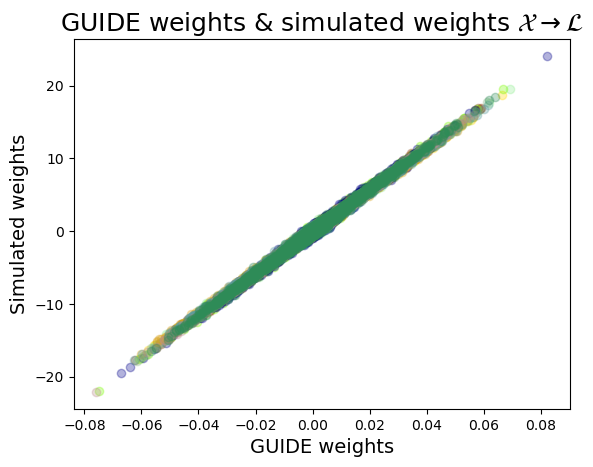

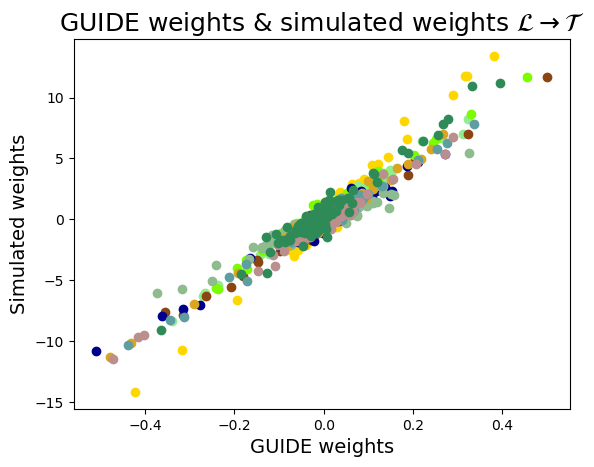

In [281]:

color=list(mcolors.CSS4_COLORS)       # shuffle colors of points (every color corresponds to a different latent factor)
shuffle(color)

y_01_plotset=[]              # prep for scatterplot 
x_01_plotset=[]

for i in range(L):
    y_01_plotset.insert(i,X.T[i])
    x_01_plotset.insert(i,W_XL.T[i])
y_01_plotset=np.array(y_01_plotset)
x_01_plotset=np.array(x_01_plotset)

y_12_plotset=[]
x_12_plotset=[]

for i in range(L):
    y_12_plotset.insert(i,(Y[i]))
    x_12_plotset.insert(i,W_LT[i])
y_12_plotset=np.array(y_12_plotset)
x_12_plotset=np.array(x_12_plotset)



fig,ax1=plt.subplots()
for i in range(L):
    plt.scatter(x_01_plotset[i],y_01_plotset[i],c=color[i],alpha=0.3)
#ax1.set_yscale('linear')
plt.title("GUIDE weights & simulated weights $\\mathcal{X} \\rightarrow \\mathcal{L}$",size=18)
plt.xlabel("GUIDE weights",size=14)
plt.ylabel("Simulated weights",size=14)
ax1.legend
#plt.savefig('sim-XL_GUIDE_M1e6-L50-T1e3.png',dpi=400)
plt.show()

#plt.scatter(g12_est,gammas_out_Y1Y2)
fig,ax1=plt.subplots()
for i in range(L):
    plt.scatter(x_12_plotset[i],y_12_plotset[i],c=color[i])
plt.title("GUIDE weights & simulated weights $\\mathcal{L} \\rightarrow \\mathcal{T}$",size=18)
plt.xlabel("GUIDE weights",size=14)
plt.ylabel("Simulated weights",size=14)
ax1.legend
#plt.savefig('sim-LT_GUIDE_M1e6-L50-T1e3.png',dpi=400)
plt.show()


**Entropy plots:**

In [282]:
ent_XL_GUIDE, ent_LT_GUIDE, ent_XL_SVD, ent_LT_SVD, bad_L, bad_L_diff = GUIDE.entropy_plot(G, L_start=1, L_stop=100, metric='contrib')

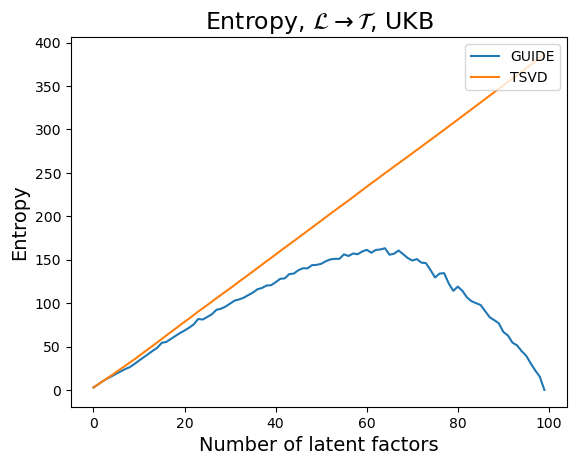

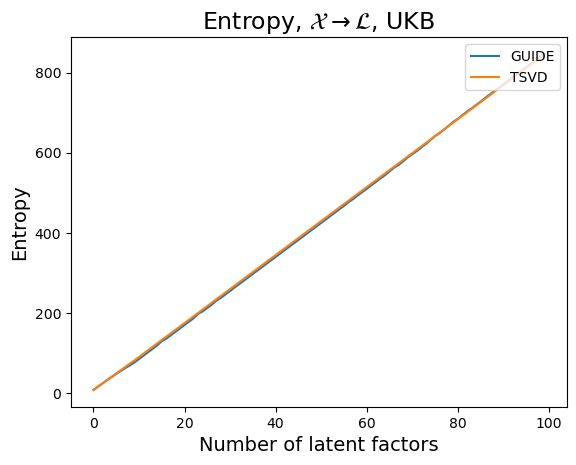

In [283]:
# entropy plots 

plt.plot(ent_LT_GUIDE,label="GUIDE")
plt.plot(ent_LT_SVD,label="TSVD")
plt.legend(loc='upper right')
plt.ylabel('Entropy',size=14)
plt.xlabel('Number of latent factors',size=14)
plt.title("Entropy, $\\mathcal{L} \\rightarrow \\mathcal{T}$, UKB",size=17)

#plt.savefig('entropy-LT___.png',dpi=400)
plt.show()

plt.plot(ent_XL_GUIDE,label="GUIDE")
plt.plot(ent_XL_SVD,label="TSVD")
plt.legend(loc='upper right')
plt.ylabel('Entropy',size=14)
plt.xlabel('Number of latent factors',size=14)
plt.title("Entropy, $\\mathcal{X} \\rightarrow \\mathcal{L}$, UKB",size=17)

#plt.savefig('entropy-LT___.png',dpi=400)
plt.show()


plt.plot(ent_XL_SVD-ent_XL_GUIDE)
plt.ylabel('Entropy',size=14)
plt.xlabel('Number of latent factors',size=14)
plt.title("Entropy difference, $\\mathcal{X} \\rightarrow \\mathcal{L}$, UKB",size=17)


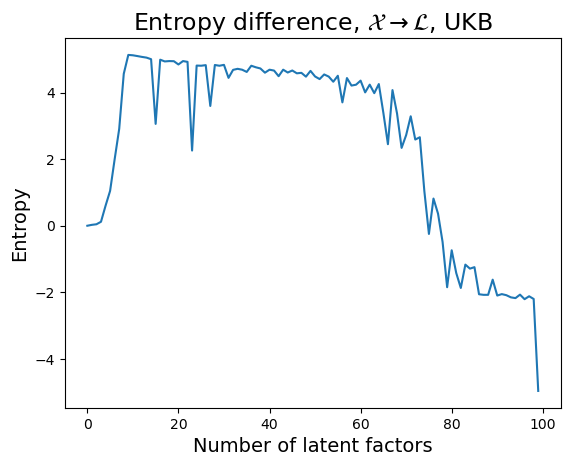

In [287]:
plt.plot(np.array(ent_XL_SVD)-np.array(ent_XL_GUIDE))
plt.ylabel('Entropy',size=14)
plt.xlabel('Number of latent factors',size=14)
plt.title("Entropy difference, $\\mathcal{X} \\rightarrow \\mathcal{L}$, UKB",size=17)
plt.show()